Found images: 728


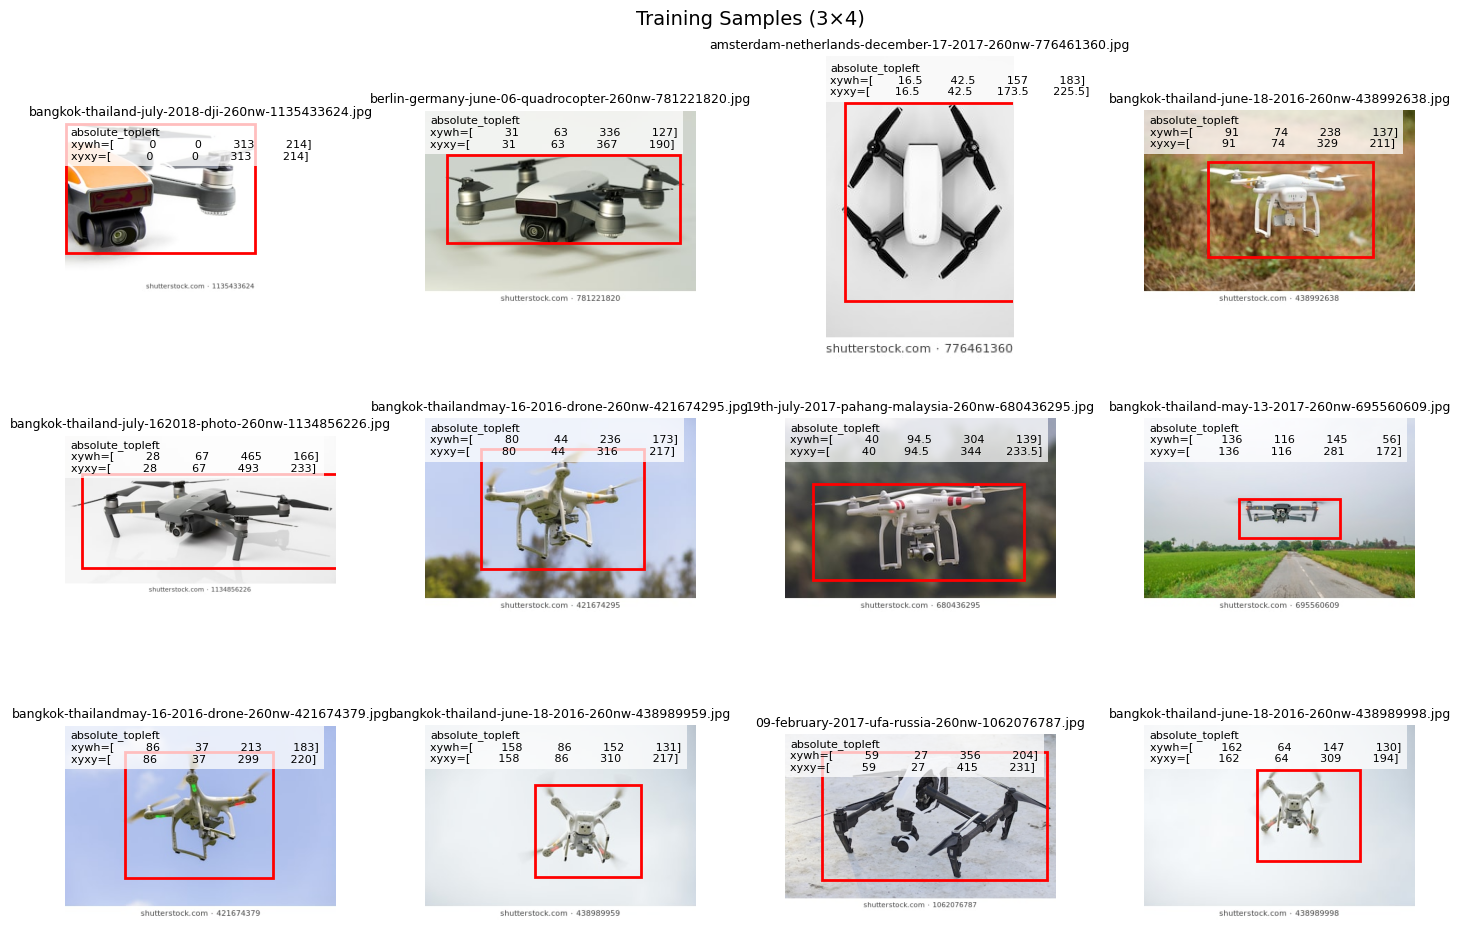

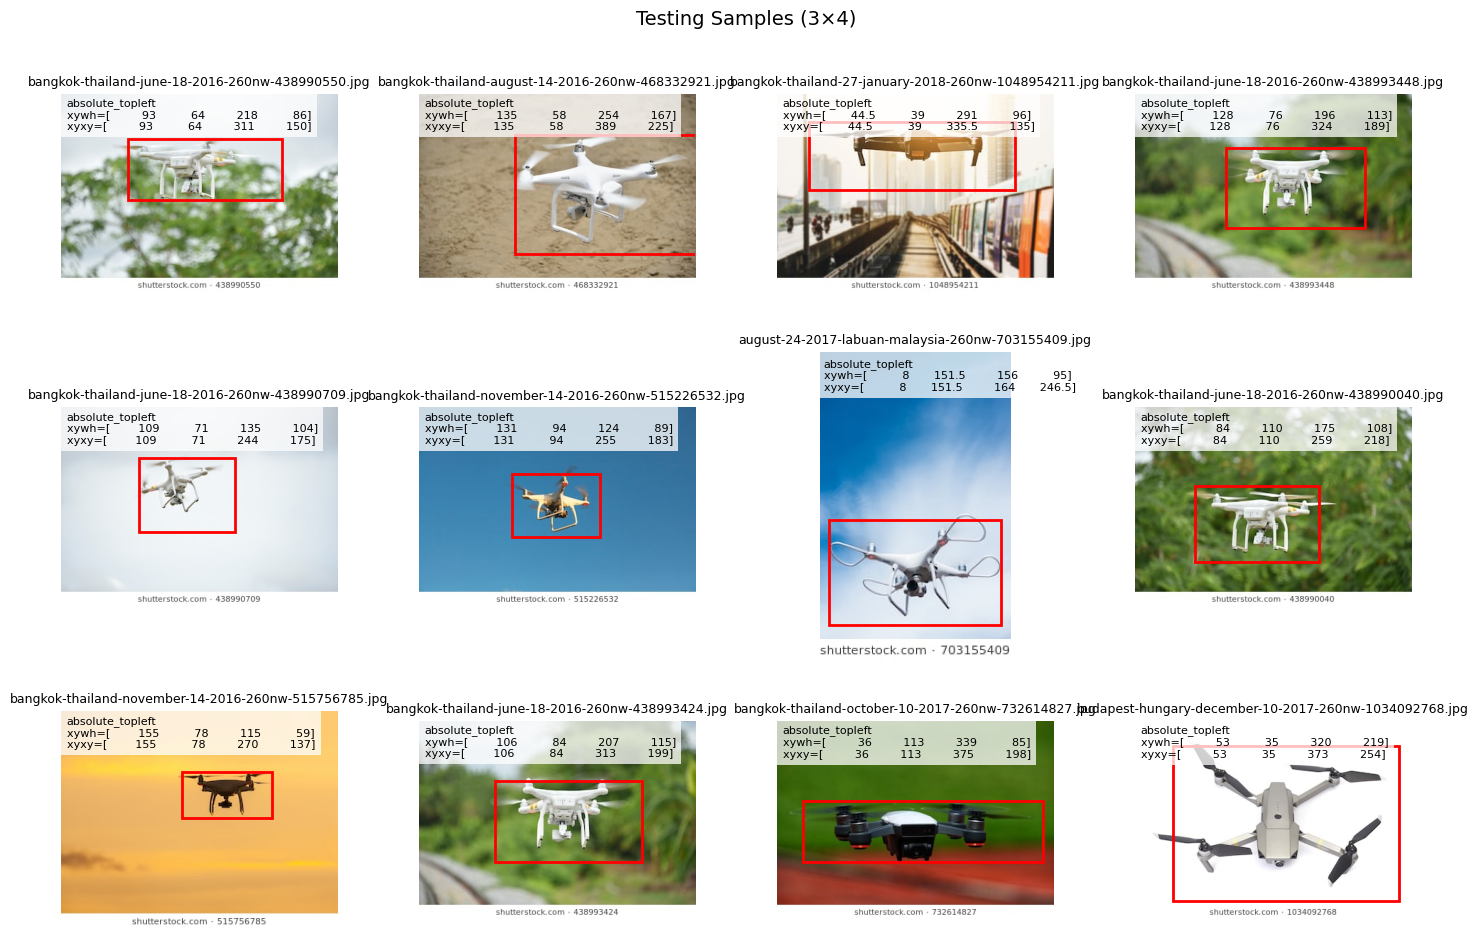

In [27]:
import os, glob, random, zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# --- Your zip paths ---
IMG_ZIP   = "/content/sample_data/image-20210112T150225Z-001-1 (1).zip"
LABEL_ZIP = "/content/sample_data/label-20210112T150240Z-001 (1).zip"

# --- Extract dirs ---
extracted_img_dir   = "/content/extracted_images"
extracted_label_dir = "/content/extracted_labels"

os.makedirs(extracted_img_dir, exist_ok=True)
os.makedirs(extracted_label_dir, exist_ok=True)

def unzip(zip_path, out_dir):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(out_dir)

unzip(IMG_ZIP, extracted_img_dir)
unzip(LABEL_ZIP, extracted_label_dir)

IMG_EXTS = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff","*.webp")

def list_images(img_dir):
    files = []
    for e in IMG_EXTS:
        files += glob.glob(str(Path(img_dir) / "**" / e), recursive=True)  # recursive
    return sorted(files)

def find_label_for_image(img_path, label_root):
    stem = Path(img_path).stem
    matches = glob.glob(str(Path(label_root) / "**" / f"{stem}.txt"), recursive=True)  # recursive
    return matches[0] if matches else None

def read_labels(label_path):
    if label_path is None or (not os.path.exists(label_path)):
        return np.zeros((0,4), dtype=float)
    rows = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            nums = list(map(float, parts))
            # accept either: x y w h  OR  class x y w h
            if len(nums) == 4:
                rows.append(nums)
            elif len(nums) >= 5:
                rows.append(nums[1:5])
            else:
                raise ValueError(f"Bad label line: {line}")
    return np.array(rows, dtype=float) if rows else np.zeros((0,4), dtype=float)

def guess_mode(boxes):
    if boxes.size == 0:
        return "none"
    return "normalized_center" if np.all((boxes >= 0) & (boxes <= 1)) else "absolute_topleft"

def to_xyxy(box, mode, W, H):
    x, y, w, h = box
    if mode == "normalized_center":   # YOLO: xc,yc,w,h in [0,1]
        xc, yc = x*W, y*H
        ww, hh = w*W, h*H
        return xc-ww/2, yc-hh/2, xc+ww/2, yc+hh/2
    elif mode == "absolute_topleft":  # x,y,w,h in pixels
        return x, y, x+w, y+h
    else:
        raise ValueError(mode)

def plot_grid(image_paths, label_root, title):
    fig, axes = plt.subplots(3, 4, figsize=(14, 10))
    axes = axes.ravel()

    for ax, img_path in zip(axes, image_paths):
        img = Image.open(img_path).convert("RGB")
        W, H = img.size

        label_path = find_label_for_image(img_path, label_root)
        boxes = read_labels(label_path)
        mode = guess_mode(boxes)

        ax.imshow(img)
        ax.set_title(Path(img_path).name, fontsize=9)
        ax.axis("off")

        # show raw xywh AND converted xyxy for the first box
        if boxes.size > 0:
            xywh0 = boxes[0].round(4)
            x1,y1,x2,y2 = to_xyxy(boxes[0], mode, W, H)
            xyxy0 = np.array([x1,y1,x2,y2]).round(1)
            info = f"{mode}\nxywh={xywh0}\nxyxy={xyxy0}"
        else:
            info = f"{mode}\nNO LABEL\nlabel_path={label_path}"

        ax.text(0.02, 0.98, info, transform=ax.transAxes, va="top", fontsize=8,
                bbox=dict(facecolor="white", alpha=0.75, edgecolor="none"))

        # draw boxes
        for b in boxes:
            x1,y1,x2,y2 = to_xyxy(b, mode, W, H)
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2,
                                     edgecolor="red", facecolor="none")
            ax.add_patch(rect)

    for ax in axes[len(image_paths):]:
        ax.axis("off")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# --- Sample 12 train/test ---
all_imgs = list_images(extracted_img_dir)
print("Found images:", len(all_imgs))
assert len(all_imgs) > 0, "No images found after unzip. Check zip contents."

random.seed(42)
random.shuffle(all_imgs)

split = int(0.8 * len(all_imgs))
train_imgs = all_imgs[:split]
test_imgs  = all_imgs[split:]

train_sample = random.sample(train_imgs, k=min(12, len(train_imgs)))
test_sample  = random.sample(test_imgs,  k=min(12, len(test_imgs)))

plot_grid(train_sample, extracted_label_dir, "Training Samples (3×4)")
plot_grid(test_sample,  extracted_label_dir, "Testing Samples (3×4)")



In [28]:
import os

yaml_content = """
path: /content/uav_dataset  # Dataset root directory
train: images/train        # Train images path relative to 'path'
val: images/val          # Val images path relative to 'path'
test: images/test        # Test images path relative to 'path'

names: [uav]             # Class names
"""

output_dir = "/content/uav_dataset"
os.makedirs(output_dir, exist_ok=True)

yaml_file_path = os.path.join(output_dir, "uav.yaml")

with open(yaml_file_path, "w") as f:
    f.write(yaml_content)

print(f"YAML configuration saved to {yaml_file_path}")

YAML configuration saved to /content/uav_dataset/uav.yaml


In [29]:
import os

yaml_content = """
path: "/content/extracted_images/image"
train: train
val: val
test: test

# Specify the root directory where label subdirectories (train, val, test) are located.
# YOLO will look for labels in {labels}/train, {labels}/val, {labels}/test.
labels: /content/extracted_labels
names: [uav]
"""

output_dir = "/content/uav_dataset"
os.makedirs(output_dir, exist_ok=True)

yaml_file_path = os.path.join(output_dir, "uav.yaml")

with open(yaml_file_path, "w") as f:
    f.write(yaml_content)

print(f"YAML configuration saved to {yaml_file_path}")

YAML configuration saved to /content/uav_dataset/uav.yaml


In [33]:
import os
import shutil
from pathlib import Path
import random
import zipfile # Added for unzip function
import glob # Added for list_images and find_label_for_image
import numpy as np # Added for read_labels and guess_mode
from PIL import Image # Needed to get image dimensions

# Re-defining necessary functions and variables to ensure cell independence
# (These were originally defined in QZz3t2EIZhRV)
IMG_ZIP   = "/content/sample_data/image-20210112T150225Z-001-1 (1).zip"
LABEL_ZIP = "/content/sample_data/label-20210112T150240Z-001 (1).zip"

extracted_img_dir   = "/content/extracted_images"
extracted_label_dir = "/content/extracted_labels"

IMG_EXTS = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff","*.webp")

def unzip(zip_path, out_dir):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(out_dir)

def list_images(img_dir):
    files = []
    for e in IMG_EXTS:
        files += glob.glob(str(Path(img_dir) / "**" / e), recursive=True)
    return sorted(files)

def find_label_for_image(img_path, label_root):
    stem = Path(img_path).stem
    matches = glob.glob(str(Path(label_root) / "**" / f"{stem}.txt"), recursive=True)
    return matches[0] if matches else None

def read_labels(label_path):
    if label_path is None or (not os.path.exists(label_path)):
        return np.zeros((0,4), dtype=float)
    rows = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            nums = list(map(float, parts))
            # accept either: x y w h  OR  class x y w h
            if len(nums) == 4:
                rows.append(nums)
            elif len(nums) >= 5:
                rows.append(nums[1:5]) # Assuming class is 0 if 5 parts, and we only care about the box
            else:
                raise ValueError(f"Bad label line: {line}")
    return np.array(rows, dtype=float) if rows else np.zeros((0,4), dtype=float)

def guess_mode(boxes):
    if boxes.size == 0:
        return "none"
    # Heuristic: if any coordinate is > 1.0, assume absolute pixels
    return "normalized_center" if np.all((boxes >= 0) & (boxes <= 1)) else "absolute_topleft"

# Clear and re-extract data to ensure source files are present
# Remove existing extracted directories if they exist
if os.path.exists(extracted_img_dir):
    shutil.rmtree(extracted_img_dir)
os.makedirs(extracted_img_dir, exist_ok=True)

if os.path.exists(extracted_label_dir):
    shutil.rmtree(extracted_label_dir)
os.makedirs(extracted_label_dir, exist_ok=True)

# Re-unzip the original data
unzip(IMG_ZIP, extracted_img_dir)
unzip(LABEL_ZIP, extracted_label_dir)

# Re-generate image lists after re-unzipping
all_imgs = list_images(extracted_img_dir)
print("Found images after re-unzip:", len(all_imgs))
assert len(all_imgs) > 0, "No images found after re-unzip. Check zip contents."

random.seed(42)
random.shuffle(all_imgs)

split = int(0.8 * len(all_imgs))
train_imgs = all_imgs[:split]
test_imgs  = all_imgs[split:]

# Define the new consolidated base directory for the dataset
consolidated_dataset_root = Path("/content/uav_dataset")

# Define target split directories for images under the consolidated root
train_img_target_dir = consolidated_dataset_root / "images" / "train"
val_img_target_dir = consolidated_dataset_root / "images" / "val"
test_img_target_dir = consolidated_dataset_root / "images" / "test"

# Define target split directories for labels under the consolidated root
train_label_target_dir = consolidated_dataset_root / "labels" / "train"
val_label_target_dir = consolidated_dataset_root / "labels" / "val"
test_label_target_dir = consolidated_dataset_root / "labels" / "test"

# Create all necessary directories (and clear if they existed from previous run)
for d in [train_img_target_dir, val_img_target_dir, test_img_target_dir,
          train_label_target_dir, val_label_target_dir, test_label_target_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

# Re-split train_imgs to get a validation set
random.seed(42) # Ensure reproducibility if this cell is rerun
random.shuffle(train_imgs)
val_split_idx = int(0.1 * len(train_imgs)) # 10% of train_imgs for validation
val_set_imgs = train_imgs[:val_split_idx]
actual_train_set_imgs = train_imgs[val_split_idx:]

# Helper function to move image and its corresponding label, converting to YOLO format if necessary
def move_image_and_label(image_path_str, dest_img_dir, dest_label_dir, source_label_root_path):
    img_path = Path(image_path_str)

    # Move image
    shutil.copy(str(img_path), dest_img_dir / img_path.name) # Use copy, not move, to avoid issues if source is also a target

    label_path_src = find_label_for_image(image_path_str, source_label_root_path)
    label_path_dst = dest_label_dir / (img_path.stem + ".txt")

    if label_path_src and Path(label_path_src).exists():
        # Read image dimensions
        with Image.open(img_path) as img_pil:
            W, H = img_pil.size

        # Read raw boxes
        boxes_raw = read_labels(label_path_src)

        if boxes_raw.size > 0:
            mode = guess_mode(boxes_raw)
            yolo_labels = []
            for box in boxes_raw:
                x, y, w, h = box
                if mode == "absolute_topleft": # x,y,w,h in pixels (top-left corner)
                    # Convert to normalized center_x, center_y, width, height
                    xc = (x + w / 2) / W
                    yc = (y + h / 2) / H
                    nw = w / W
                    nh = h / H
                elif mode == "normalized_center": # xc,yc,w,h already normalized
                    # Assume these are already xc,yc,w,h normalized
                    xc, yc, nw, nh = x, y, w, h
                else:
                    # Should not happen with current guess_mode, but as a safeguard
                    print(f"Warning: Unknown box mode '{mode}' for {img_path.name}. Skipping label.")
                    continue

                # Ensure coordinates are within 0-1 bounds for YOLO
                xc = np.clip(xc, 0.0, 1.0)
                yc = np.clip(yc, 0.0, 1.0)
                nw = np.clip(nw, 0.0, 1.0)
                nh = np.clip(nh, 0.0, 1.0)

                # YOLO format: class_id center_x center_y width height
                yolo_labels.append(f"0 {xc:.6f} {yc:.6f} {nw:.6f} {nh:.6f}")

            # Write processed labels to the new destination
            with open(label_path_dst, "w") as f:
                f.write("\n".join(yolo_labels))
        else:
            # If no boxes, create an empty label file (or skip, depending on preference)
            with open(label_path_dst, "w") as f:
                pass # Empty file for images with no labels
    else:
        print(f"Warning: No label found or label file missing for image: {img_path.name} in {source_label_root_path}")
        # Create an empty label file if no label was found, to avoid YOLO errors for missing files
        with open(label_path_dst, "w") as f:
            pass

print("Organizing training data...")
for img_path_str in actual_train_set_imgs:
    move_image_and_label(img_path_str, train_img_target_dir, train_label_target_dir, extracted_label_dir)

print("Organizing validation data...")
for img_path_str in val_set_imgs:
    move_image_and_label(img_path_str, val_img_target_dir, val_label_target_dir, extracted_label_dir)

print("Organizing testing data...")
for img_path_str in test_imgs:
    move_image_and_label(img_path_str, test_img_target_dir, test_label_target_dir, extracted_label_dir)

print("Dataset organization complete for YOLO training.")

# Correcting the YAML configuration for YOLO (this part was already correct)
yaml_content_fixed = """
path: /content/uav_dataset
train: images/train
val: images/val
test: images/test

labels: labels
names: [uav]
"""

output_dir = "/content/uav_dataset"
os.makedirs(output_dir, exist_ok=True)

yaml_file_path = os.path.join(output_dir, "uav.yaml")

with open(yaml_file_path, "w") as f:
    f.write(yaml_content_fixed)

print(f"Corrected YAML configuration saved to {yaml_file_path}")

!pip -q install ultralytics
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # n/s/m depending on your GPU

model.train(
    data="/content/uav_dataset/uav.yaml",
    imgsz=640,
    epochs=30,
    batch=16,
    device='cpu' # Changed from device=0 to device='cpu'
)

Found images after re-unzip: 314
Organizing training data...
Organizing validation data...
Organizing testing data...
Dataset organization complete for YOLO training.
Corrected YAML configuration saved to /content/uav_dataset/uav.yaml
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/uav_dataset/uav.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a0e82a74e90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [36]:
metrics = model.val(data="/content/uav_dataset/uav.yaml", split="test", imgsz=640)
print(metrics)


Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 412.8±236.3 MB/s, size: 15.7 KB)
val: Scanning /content/uav_dataset/labels/test.cache... 63 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 63/63 48.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 3.2s/it 12.9s
                   all         63         63      0.928      0.889       0.92      0.506
Speed: 1.9ms preprocess, 186.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/runs/detect/val2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a0e82a7a3f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          

In [50]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np

# -----------------------------
# Your Dataset (unchanged)
# -----------------------------
class UAVDataset(Dataset):
    def __init__(self, img_paths, label_dir, transforms=None):
        self.img_paths = img_paths
        self.label_dir = label_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        W, H = img.size

        stem = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(self.label_dir, stem + ".txt")

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = list(map(float, line.strip().split()))
                    # supports: class xc yc w h OR xc yc w h
                    if len(parts) >= 5:
                        xc, yc, w, h = parts[1:5]
                    else:
                        xc, yc, w, h = parts[:4]

                    # YOLO normalized center -> pixel corners
                    x1 = (xc - w/2) * W
                    y1 = (yc - h/2) * H
                    x2 = (xc + w/2) * W
                    y2 = (yc + h/2) * H
                    boxes.append([x1, y1, x2, y2])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)  # 1 class: UAV (background=0)
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}

        if self.transforms:
            img = self.transforms(img)

        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))


# -----------------------------
# Performance evaluation code
# -----------------------------
def box_iou(boxes1, boxes2):
    """IoU matrix between boxes1 (N,4) and boxes2 (M,4) in [x1,y1,x2,y2]."""
    if boxes1.numel() == 0 or boxes2.numel() == 0:
        return torch.zeros((boxes1.shape[0], boxes2.shape[0]), device=boxes1.device)

    xa = torch.max(boxes1[:, None, 0], boxes2[None, :, 0])
    ya = torch.max(boxes1[:, None, 1], boxes2[None, :, 1])
    xb = torch.min(boxes1[:, None, 2], boxes2[None, :, 2])
    yb = torch.min(boxes1[:, None, 3], boxes2[None, :, 3])

    inter = (xb - xa).clamp(min=0) * (yb - ya).clamp(min=0)
    area1 = (boxes1[:, 2] - boxes1[:, 0]).clamp(min=0) * (boxes1[:, 3] - boxes1[:, 1]).clamp(min=0)
    area2 = (boxes2[:, 2] - boxes2[:, 0]).clamp(min=0) * (boxes2[:, 3] - boxes2[:, 1]).clamp(min=0)
    union = area1[:, None] + area2[None, :] - inter + 1e-9
    return inter / union


def match_predictions(pred_boxes, pred_scores, gt_boxes, iou_thresh=0.5):
    """
    Greedy score-based matching: each GT can match at most one prediction.
    Returns arrays tp, fp (in descending score order) and #GT.
    """
    order = torch.argsort(pred_scores, descending=True)
    pred_boxes = pred_boxes[order]
    pred_scores = pred_scores[order]

    K = pred_boxes.shape[0]
    tp = torch.zeros(K, dtype=torch.int32, device=pred_boxes.device)
    fp = torch.zeros(K, dtype=torch.int32, device=pred_boxes.device)

    G = gt_boxes.shape[0]
    if G == 0:
        fp[:] = 1
        return tp, fp, 0

    ious = box_iou(pred_boxes, gt_boxes)
    gt_used = torch.zeros(G, dtype=torch.bool, device=pred_boxes.device)

    for i in range(K):
        best_iou, best_j = torch.max(ious[i], dim=0)
        if best_iou >= iou_thresh and not gt_used[best_j]:
            tp[i] = 1
            gt_used[best_j] = True
        else:
            fp[i] = 1

    return tp, fp, int(G)


def compute_ap(tp, fp, num_gt):
    """AP from PR curve (single class)."""
    if num_gt == 0:
        return 0.0

    tp = tp.astype(np.float64)
    fp = fp.astype(np.float64)

    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)

    recall = tp_cum / (num_gt + 1e-12)
    precision = tp_cum / (tp_cum + fp_cum + 1e-12)

    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])

    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return float(ap)


@torch.no_grad()
def evaluate_faster_rcnn(model, dataloader, device, iou_thresh=0.5, score_thresh=0.5):
    """
    Returns Precision/Recall/F1 at score_thresh and AP@iou_thresh.
    Assumes single class UAV is label==1 in predictions and targets.
    """
    model.eval()
    all_tp, all_fp = [], []
    total_gt = 0

    # Access the dataset directly from the dataloader to get image paths
    test_dataset_ref = dataloader.dataset

    for images_tensor_batch, targets_batch in dataloader:
        for i, (image_tensor, target) in enumerate(zip(images_tensor_batch, targets_batch)):
            # Get original image path using the image_id from the target
            img_idx = target["image_id"].item()
            img_path = test_dataset_ref.img_paths[img_idx]

            gt_boxes = target["boxes"].to(device)

            # Perform prediction using the image path
            # Set verbose=False to suppress individual prediction logs
            results = model.predict(source=img_path, verbose=False)

            # Process results from Ultralytics
            if results and len(results) > 0: # Ensure results are not empty
                pred_result = results[0] # Get the first (and likely only) result object for the image

                # Ensure boxes, scores, and labels are available. If no detections, these might be empty.
                if len(pred_result.boxes) > 0:
                    pred_boxes = pred_result.boxes.xyxy.cpu()
                    pred_scores = pred_result.boxes.conf.cpu()
                    pred_labels = pred_result.boxes.cls.cpu()
                else:
                    pred_boxes = torch.empty((0, 4), device=device)
                    pred_scores = torch.empty((0,), device=device)
                    pred_labels = torch.empty((0,), device=device)
            else:
                pred_boxes = torch.empty((0, 4), device=device)
                pred_scores = torch.empty((0,), device=device)
                pred_labels = torch.empty((0,), device=device)

            # Move predictions to the specified device for metric computation
            pred_boxes = pred_boxes.to(device)
            pred_scores = pred_scores.to(device)
            pred_labels = pred_labels.to(device)

            keep = (pred_labels == 0) & (pred_scores >= score_thresh) # Assuming class 0 is 'uav'
            pred_boxes = pred_boxes[keep]
            pred_scores = pred_scores[keep]

            tp, fp, num_gt = match_predictions(pred_boxes, pred_scores, gt_boxes, iou_thresh=iou_thresh)
            all_tp.append(tp.cpu().numpy())
            all_fp.append(fp.cpu().numpy())
            total_gt += num_gt

    tp_flat = np.concatenate(all_tp) if all_tp else np.array([], dtype=np.int32)
    fp_flat = np.concatenate(all_fp) if all_fp else np.array([], dtype=np.int32)

    TP = int(tp_flat.sum())
    FP = int(fp_flat.sum())
    FN = int(total_gt - TP)

    precision = TP / (TP + FP + 1e-12)
    recall = TP / (total_gt + 1e-12)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)

    ap50 = compute_ap(tp_flat, fp_flat, total_gt)

    return {
        "IoU_thresh": iou_thresh,
        "score_thresh": score_thresh,
        "GT": total_gt,
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "Precision": float(precision),
        "Recall": float(recall),
        "F1": float(f1),
        "AP@0.5" if iou_thresh == 0.5 else f"AP@{iou_thresh}": float(ap50),
    }
